# Impact of the initialization

> In this study, we endeavor to ascertain a more efficacious initialization approach for K-means clustering, specifically focusing on the PCA+K-means method. This approach is grounded in the theoretical analysis positing that the optimal solution for K-means clustering is inherently situated within the PCA-subspace. Our objective is to empirically validate the hypothesis that the PCA+K-means method generally yields superior performance outcomes.

> To this end, we will conduct a comparative analysis of the PCA+K-means method against four alternative initialization strategies: random initialization, the K-means++ method, the KR method, and the KKZ method.

> This investigation is extensively influenced by the experimental frameworks and insights presented in the paper titled **PCA-guided search for K-means**. Our work aims to not only replicate but also expand to other datasets and provide a careful analysis.

**Metrics**

Our evaluation is based on two key metrics: **Clustering Accuracy** and the **Davies-Bouldin (DB) index**.

Accuracy, though typically used in supervised learning, provides insight when ground truth labels are available, allowing for a direct comparison of clustering assignments. The DB index offers a nuanced understanding of the cluster quality, assessing both inter-cluster separation and intra-cluster compactness . This dual-metric approach facilitates a comprehensive assessment of the clustering outcomes under different initialization scenarios.

In [ ]:
# If needed 
!pip install ucimlrepo
!pip install seaborn

In [ ]:
# Imports

from utils import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
import tensorflow as tf

from sklearn import datasets

import warnings
warnings.filterwarnings("ignore")

**The 4 types of initialization**



*   **Random** is the naïve approach


*   **KR method** was developed by Kaufman and Rousseeuw. It selects the initial centroids one after another. The first centroid is the most centrally located in the set of objects. The remaining centroids are then chosen in a certain way in which each chosen centroid is expected to be far away from
the previously selected centroids but still have many data points close
to it.


*  **KKZ method** was developed by Katsavounidis & al. It proposes that the first centroid should be the one which has the maximum norm. Then for each nonselected data point, it sets the minimal distance between it and the centroid set as the distance between them, then choose the candidate point which has the maximal distance between it and the centroids as the next centroid. It repeats this until K centroids have been chosen.


*   **K-means++** was developed by Arthur and Vassilvitskii. It proposes a
method which selects the K centroids greedily. The first centroid is
selected randomly from the data set. Then the next point x is chosen
as the centroid with a certain probability. Repeated until K centroids are identified.





**Methodology**

In this study, we adopt a systematic approach to investigate the influence of various initialization methods on the performance of K-means clustering. Our methodology is structured as follows:

**Datasets**: We have selected six diverse datasets to ensure a comprehensive analysis across different types of data. These datasets are:

**Iris Dataset**:
- Description: A classic dataset in machine learning, the Iris dataset contains measurements of 150 iris flowers, representing three different species. Each instance is described by four features: sepal length, sepal width, petal length, and petal width.
- Purpose in Experiment: This dataset serves as an excellent baseline for clustering algorithms due to its simplicity and well-understood characteristics.


**Wine Dataset**:
- Description: The Wine dataset consists of chemical analysis results of 178 wine samples, derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each wine, providing a rich multidimensional feature space.
- Purpose in Experiment: This dataset offers a more complex clustering challenge than the Iris dataset due to a higher number of features and instances.


**Image Segmentation Dataset**:
- Description: Used for evaluating image segmentation tasks, this dataset contains instances derived from images, each represented by various features extracted for segmentation purposes, such as color, texture, and shape descriptors.
- Purpose in Experiment: It provides a practical application of clustering in image processing and pattern recognition, with a focus on segmenting distinct regions in images.


**Glass Dataset**:
- Description: The Glass dataset includes data for classifying types of glass based on their oxide content. It encompasses several oxide types as features and is used to differentiate between glass types for forensic science applications.
- Purpose in Experiment: With its unique application in forensic analysis, this dataset adds diversity to the clustering problems, focusing on material classification.

**MNIST Handwritten Digits Dataset**:
- Description: Comprising 8-bit grayscale images of digits 0 through 9, the MNIST dataset is a benchmark in machine learning for image data. For the experiment, we select the first 50 images from each class, flattening them into vectors of dimension 784.
- Purpose in Experiment: This dataset represents a significant challenge due to its high dimensionality and the complexity inherent in image data, making it ideal for testing the robustness of clustering algorithms.

**Initialization Methods**: We will apply K-means clustering using four different initialization methods:

- K-means with PCA reduction (2, 3 or features/2 number of components then take the best one according to DB index)
- Random initialization
- K-means++
- KR
- KKZ

**Number of Runs**:
- Each clustering experiment will be repeated 100 times to mitigate the variability inherent in the clustering process and initialization.

**Metrics Evaluation**:
- Accuracy: proportion of correctly clustered instances.
- Davies-Bouldin Index: to assess the quality of clustering in terms of intra-cluster compactness and inter-cluster separation.
- Averaging Results: The results from the 100 runs for each dataset and initialization method will be averaged to provide a more robust and reliable measure of performance.

This methodology ensures a rigorous and comprehensive evaluation of the impact of initialization on K-means clustering, providing valuable insights into the most effective practices in different data scenarios.

In [ ]:
def load_mnist_subset():
    # Load the MNIST dataset
    (X_train, y_train), _ = tf.keras.datasets.mnist.load_data()

    # Select first 50 images from each class (digit 0-9)
    selected_images = []
    selected_labels = []
    for digit in range(10):
        digit_images = X_train[y_train == digit]
        selected_images.append(digit_images[:50])
        selected_labels.extend([digit] * 50)

    # Convert list of arrays into a single array
    selected_images = np.vstack(selected_images)

    # Flatten each image to a 784-dimensional vector
    selected_images_flattened = selected_images.reshape(-1, 784)

    return selected_images_flattened, np.array(selected_labels)


def load_dataset(name):
    if name == 'iris':
        data = datasets.load_iris()
        X, y = data.data, data.target
        scaler = MyStandardScaler()
        X_scaled = scaler.fit_transform(X)
        n_clusters = 3

    if name == 'wine':
      wine = fetch_ucirepo(id=109)
      X = np.array(wine.data.features)
      y = np.array(wine.data.targets).ravel()
      scaler = MyStandardScaler()
      X_scaled = scaler.fit_transform(X)
      n_clusters = 3

    if name == 'image_segmentation':
      image_segmentation = fetch_ucirepo(id=50)
      X = np.array(image_segmentation.data.features)
      y = np.array(image_segmentation.data.targets).ravel()
      mapping = create_label_mapping(y)
      labels_num = map_labels(y, mapping)
      y = np.array(labels_num)
      scaler = MyStandardScaler()
      X_scaled = scaler.fit_transform(X)
      n_clusters = 7

    if name == 'glass':
      glass_identification = fetch_ucirepo(id=42)
      X = np.array(glass_identification.data.features)
      y = np.array(glass_identification.data.targets).ravel()
      scaler = MyStandardScaler()
      X_scaled = scaler.fit_transform(X)
      n_clusters = 7

    if name == 'mnist':
      X, y = load_mnist_subset()
      n_clusters = 10
      scaler = MyStandardScaler()
      X_scaled = scaler.fit_transform(X)

    return X_scaled, y, n_clusters


def run_kmeans(X, y, init_method, n_clusters, n_runs=100):
    db_indexes = []
    accuracies = []
    for _ in range(n_runs):
        kmeans = KMeans(k=n_clusters, init=init_method)
        kmeans.fit(X)
        db_index = davies_bouldin_score(X, kmeans.labels)
        accuracy = clustering_accuracy(y, kmeans.labels)
        db_indexes.append(db_index)
        accuracies.append(accuracy)
    return np.mean(db_indexes), np.mean(accuracies)

def pca_reduction(X, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)

In [ ]:
def experiment(dataset_name):
    X, y, n_clusters = load_dataset(dataset_name)
    init_methods = ['random', 'KR', 'k-means++', 'KKZ']
    pca_components = [X.shape[1] // 2, 3, 2]
    results = {}

    for method in init_methods:
        db_index, accuracy = run_kmeans(X, y, method, n_clusters)
        results[method] = {'DB Index': db_index, 'Accuracy': accuracy}
    # PCA-guided K-means

    pca_results = []
    for components in pca_components:
        X_pca = pca_reduction(X, components)
        db_index, accuracy = run_kmeans(X_pca.real, y, 'random', n_clusters)
        pca_results.append((components, db_index, accuracy))
    best_pca_result = min(pca_results, key=lambda x: x[1])  # Select best based on DB Index
    results['PCA'] = {'DB Index': best_pca_result[1], 'Accuracy': best_pca_result[2]}

    return results

In [ ]:
dataset_name = 'iris'
iris_results = experiment(dataset_name)
print(iris_results)

{'random': {'DB Index': 0.8158799568204315, 'Accuracy': 0.7975999999999999}, 'KR': {'DB Index': 0.8324162130910139, 'Accuracy': 0.8133333333333331}, 'k-means++': {'DB Index': 0.8180767603723919, 'Accuracy': 0.8072666666666667}, 'KKZ': {'DB Index': 0.8275118026450466, 'Accuracy': 0.8533333333333336}, 'PCA': {'DB Index': 0.7102162138893893, 'Accuracy': 0.7818}}


In [ ]:
dataset_name = 'wine'
wine_results = experiment(dataset_name)
print(wine_results)

{'random': {'DB Index': 1.3953362613980191, 'Accuracy': 0.9447191011235955}, 'KR': {'DB Index': 1.3938008647586724, 'Accuracy': 0.9606741573033711}, 'k-means++': {'DB Index': 1.394186937224121, 'Accuracy': 0.9542134831460675}, 'KKZ': {'DB Index': 1.3938008647586724, 'Accuracy': 0.9606741573033711}, 'PCA': {'DB Index': 0.5968590786174842, 'Accuracy': 0.9590449438202248}}


In [ ]:
dataset_name = 'image_segmentation'
image_segmentation_results = experiment(dataset_name)
print(image_segmentation_results)

{'random': {'DB Index': 1.2753948193838343, 'Accuracy': 0.6269523809523809}, 'KR': {'DB Index': 0.639936675950511, 'Accuracy': 0.3333333333333334}, 'k-means++': {'DB Index': 1.2012433743357553, 'Accuracy': 0.6131904761904762}, 'KKZ': {'DB Index': 0.8783569928468785, 'Accuracy': 0.45238095238095233}, 'PCA': {'DB Index': 0.7429544066135574, 'Accuracy': 0.5082380952380952}}


In [ ]:
dataset_name = 'glass'
glass_results = experiment(dataset_name)
print(glass_results)

{'random': {'DB Index': 1.1819160439759135, 'Accuracy': 0.5602336448598131}, 'KR': {'DB Index': 0.8114388460250177, 'Accuracy': 0.5186915887850468}, 'k-means++': {'DB Index': 1.1135837734318528, 'Accuracy': 0.5616822429906542}, 'KKZ': {'DB Index': 1.0385501297818092, 'Accuracy': 0.5186915887850468}, 'PCA': {'DB Index': 0.7261701229590517, 'Accuracy': 0.6156542056074766}}


In [ ]:
dataset_name = 'mnist'
mnist_results = experiment(dataset_name)
print(mnist_results)

11490434/11490434 [==============================] - 0s 0us/step
{'random': {'DB Index': 2.6619562080121226, 'Accuracy': 0.4842}, 'KR': {'DB Index': 0.40186478503885065, 'Accuracy': 0.11799999999999997}, 'k-means++': {'DB Index': 2.59205962906801, 'Accuracy': 0.46176}, 'KKZ': {'DB Index': 2.2660317604427958, 'Accuracy': 0.396}, 'PCA': {'DB Index': 0.817351070463443, 'Accuracy': 0.36095999999999995}}


In [ ]:
# Consolidate results into a DataFrame
datasets = ['Iris', 'Wine', 'Image Segmentation', 'Glass', 'MNIST']
init_methods = ['random', 'KR', 'k-means++', 'KKZ', 'PCA']

# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Dataset', 'Initialization', 'DB Index', 'Accuracy'])

# Populate the DataFrame
for dataset, results in zip(datasets, [iris_results, wine_results, image_segmentation_results, glass_results, mnist_results]):
    for method in init_methods:
        db_index = results[method]['DB Index']
        accuracy = results[method]['Accuracy']
        df = df.append({'Dataset': dataset, 'Initialization': method, 'DB Index': db_index, 'Accuracy': accuracy}, ignore_index=True)

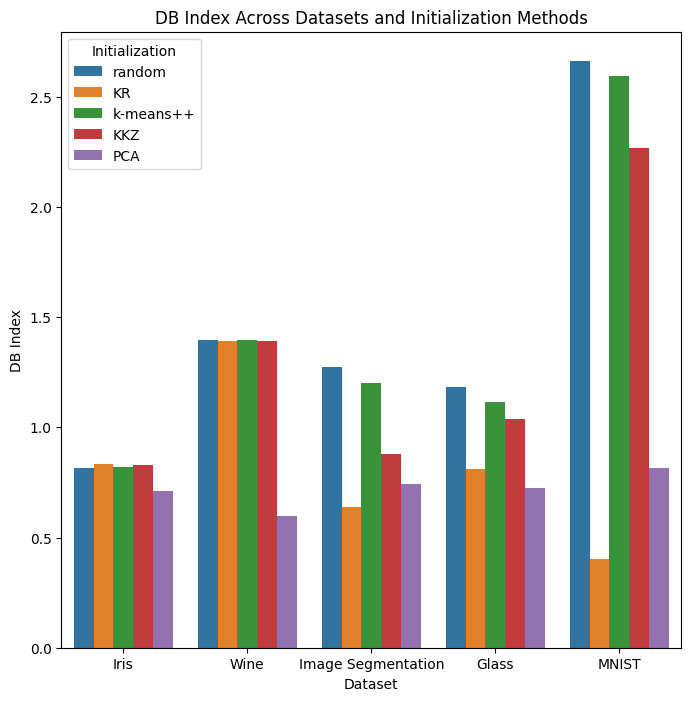

In [ ]:
plt.figure(figsize=(8, 8))
sns.barplot(x='Dataset', y='DB Index', hue='Initialization', data=df)
plt.title('DB Index Across Datasets and Initialization Methods')
plt.show()

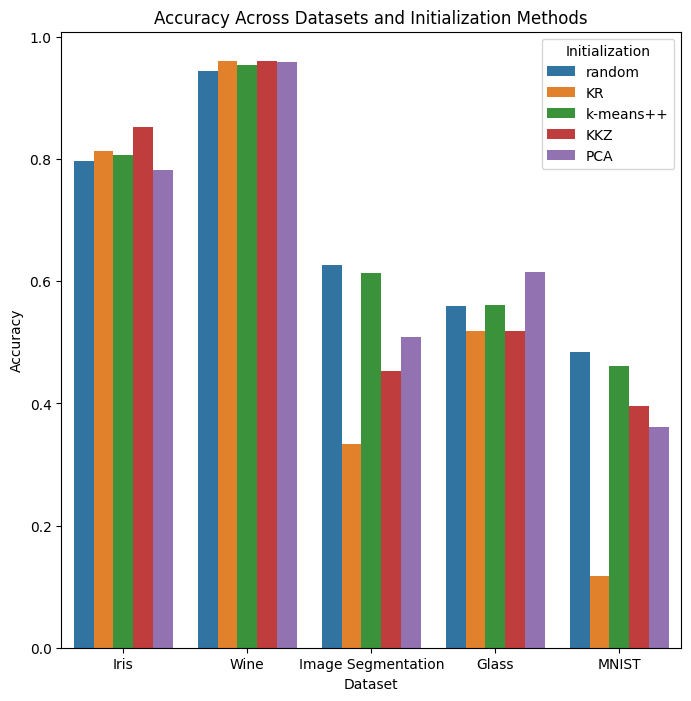

In [ ]:
plt.figure(figsize=(8, 8))
sns.barplot(x='Dataset', y='Accuracy', hue='Initialization', data=df)
plt.title('Accuracy Across Datasets and Initialization Methods')
plt.show()

**Analysis and Interpretation**

The bar plots generated from the experiment compare the Davies-Bouldin (DB) Index and Accuracy across different datasets for various initialization methods in K-means clustering. The DB Index aims for a lower score (indicating well-separated and compact clusters), while Accuracy aims for a higher score (indicating a closer match to the true labels).

PCA reduces the dimensionality of the data by projecting it onto the components that explain the most variance. This can often help K-means perform better by mitigating the curse of dimensionality and noise. PCA also helps in placing the initial centroids in the directions of maximum variance, potentially leading to better starting conditions for K-means. By emphasizing the most significant structure in the data, PCA can lead to clusters that are better separated in the reduced space, as can be inferred from the generally lower DB Index.

The PCA + K-means method generally results in a lower DB Index across most datasets, suggesting that it consistently produces clusters with better separation and compactness. It also shows competitive accuracy, being the highest on the Wine and Glass dataset, which indicates that the clusters formed are more aligned with the true labels of the data.

Despite its theoretical advantages, the PCA + K-means method does not perform as well on the MNIST dataset. The potential reasons could be:



*   High Variance Across Many Dimensions: MNIST is a high-dimensional dataset (784 dimensions) with significant variance across many of those dimensions. PCA reduces the data to fewer dimensions, which may lead to the loss of critical information that is necessary for accurate clustering of complex images like handwritten digits.
*   Non-linear Structures: The underlying structure of the MNIST data might be non-linear, which PCA (a linear method) might not capture effectively. This can lead to suboptimal initial centroids after the PCA transformation, affecting both the DB Index and accuracy.
*   Uniform Distribution of Variance: If the variance is more uniformly distributed across the dimensions, the PCA may not be as effective in identifying directions that improve the clustering performance significantly.
*   Data Sparsity: Handwritten digit images often have a lot of empty or near-empty pixels, leading to sparse data. PCA is less effective on sparse data because the low-variance components it discards might still contain important information for clustering.

Notably, KR method performs really well on the MNIST dataset regarding DB index.
Its approach to placing initial centroids both in dense regions and spread out across the dataset can lead to more effective clustering in high-dimensional spaces like MNIST.

**Limitations**

The experimental design reveals certain limitations. The PCA+K-means method was applied with a rudimentary random initialization post dimensionality reduction. A synthesis of this approach with a sophisticated initialization technique may yield superior outcomes. Additionally, the dimension reduction was confined to a narrow set of possibilities: precisely 2, 3, or half the number of features. A meticulous examination of each dataset to determine the optimal number of components might further enhance the performance.

**Conclusion**

While PCA + K-means shows theoretical and experimental arguments for being an effective initialization method for clustering, its performance on datasets like MNIST can be hindered due to the loss of information through dimensionality reduction, the presence of non-linear structures in the data, and the potential sparsity of image data. This suggests that for image datasets and other complex, high-dimensional data, alternative dimensionality reduction techniques or clustering initialization methods that preserve more of the data's inherent structure might be more appropriate.

**Coming next...**

Building upon the findings of our current research, the next notebook will delve into two notable limitations of the PCA+K-means method: its reliance on linear assumptions and its susceptibility to noise.